In [1]:
from sqlalchemy import create_engine
from sqlalchemy import inspect
import pandas as pd
import matplotlib.pyplot as plt
import datetime

In [2]:
engine = create_engine("sqlite:///eda_project_data.db")

In [3]:
insp = inspect(engine)
print(insp.get_table_names())

['mta_data', 'nyc_wifi', 'station_zips']


In [4]:
# import mta data with station zips from SQL database by joining mta_data and station_zips tables
turnstiles_df = pd.read_sql('''
                            WITH wifi_density AS
                                (SELECT ZIPCODE,COUNT(ZIPCODE) AS DENSITY
                                FROM nyc_wifi
                                GROUP BY ZIPCODE
                                ORDER BY DENSITY DESC)
                            SELECT m.*,s.ZIPCODE,w.DENSITY
                            FROM mta_data m
                                LEFT JOIN station_zips s ON m.STATION = s.STATION AND m.LINENAME = s.LINENAME
                                LEFT JOIN wifi_density w ON s.ZIPCODE = w.ZIPCODE;
                            ''',engine)

In [6]:
# create datetime object, convert zip codes to str, convert wifi density to int
turnstiles_df["DATE_TIME"] = pd.to_datetime(turnstiles_df.DATE + " " + turnstiles_df.TIME, 
                                            format="%m/%d/%Y %H:%M:%S")
def zips_to_str(x):
    try:
        x = str(int(x))
        if len(x) < 5:
            x = '0' + x
    except ValueError:
        x = '10007'  # would not normally make this absolute, but CORTLANDT ST Station was the only NaN value 
    return x

turnstiles_df.ZIPCODE = turnstiles_df.ZIPCODE.apply(zips_to_str)

In [7]:
turnstiles_df

,CA,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,ZIPCODE,DENSITY,DATE_TIME
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,07/10/2021,00:00:00,REGULAR,7600000,2598659,10022,86.0,2021-07-10 00:00:00
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,07/10/2021,04:00:00,REGULAR,7600008,2598664,10022,86.0,2021-07-10 04:00:00
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,07/10/2021,08:00:00,REGULAR,7600014,2598679,10022,86.0,2021-07-10 08:00:00
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,07/10/2021,12:00:00,REGULAR,7600061,2598732,10022,86.0,2021-07-10 12:00:00
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,07/10/2021,16:00:00,REGULAR,7600150,2598761,10022,86.0,2021-07-10 16:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7760887,TRAM2,R469,00-05-00,RIT-ROOSEVELT,R,RIT,07/06/2018,17:00:00,REGULAR,2761,62,10044,2.0,2018-07-06 17:00:00
7760888,TRAM2,R469,00-05-00,RIT-ROOSEVELT,R,RIT,07/06/2018,21:00:00,REGULAR,2761,62,10044,2.0,2018-07-06 21:00:00
7760889,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,07/06/2018,13:00:00,REGULAR,5554,338,10044,2.0,2018-07-06 13:00:00
7760890,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,07/06/2018,17:00:00,REGULAR,5554,343,10044,2.0,2018-07-06 17:00:00


In [8]:
# check for duplicate date entries
(turnstiles_df
    .groupby(['CA','UNIT','SCP','STATION','DATE_TIME'])
    .ENTRIES.count()
    .reset_index()
    .sort_values('ENTRIES',ascending=False)).head(5)

,CA,UNIT,SCP,STATION,DATE_TIME,ENTRIES
664689,B024,R211,00-05-00,KINGS HWY,2021-05-06 00:00:00,2
664680,B024,R211,00-05-00,KINGS HWY,2021-05-04 12:00:00,2
202941,A034,R170,03-05-03,14 ST-UNION SQ,2019-08-10 05:00:00,2
1854129,N045,R187,01-00-02,81 ST-MUSEUM,2019-07-09 09:00:00,2
202942,A034,R170,03-05-03,14 ST-UNION SQ,2019-08-10 09:00:00,2


In [9]:
turnstiles_df.sort_values(['CA','UNIT','SCP','STATION','DATE_TIME'],inplace=True,ascending=False)
turnstiles_df.drop_duplicates(subset=['CA','UNIT','SCP','STATION','DATE_TIME'],inplace=True)

In [10]:
# re-check for duplicate date entries
(turnstiles_df
    .groupby(['CA','UNIT','SCP','STATION','DATE_TIME'])
    .ENTRIES.count()
    .reset_index()
    .sort_values('ENTRIES',ascending=False))

,CA,UNIT,SCP,STATION,DATE_TIME,ENTRIES
0,A002,R051,02-00-00,59 ST,2018-06-30 00:00:00,1
5173862,R141,R031,00-03-00,34 ST-PENN STA,2018-09-18 12:00:00,1
5173874,R141,R031,00-03-00,34 ST-PENN STA,2018-09-20 12:00:00,1
5173873,R141,R031,00-03-00,34 ST-PENN STA,2018-09-20 08:00:00,1
5173872,R141,R031,00-03-00,34 ST-PENN STA,2018-09-20 04:00:00,1
...,...,...,...,...,...,...
2586931,N134,R385,00-03-00,ROCKAWAY BLVD,2021-06-16 09:00:00,1
2586930,N134,R385,00-03-00,ROCKAWAY BLVD,2021-06-16 05:00:00,1
2586929,N134,R385,00-03-00,ROCKAWAY BLVD,2021-06-16 01:00:00,1
2586928,N134,R385,00-03-00,ROCKAWAY BLVD,2021-06-15 21:00:00,1


In [11]:
turnstiles_daily = (turnstiles_df
                        .groupby(['CA','UNIT','SCP','STATION','ZIPCODE','DENSITY','DATE'],as_index=False)
                        .ENTRIES.first())

turnstiles_daily

,CA,UNIT,SCP,STATION,ZIPCODE,DENSITY,DATE,ENTRIES
0,A002,R051,02-00-00,59 ST,10022,86.0,04/24/2021,7561578
1,A002,R051,02-00-00,59 ST,10022,86.0,04/25/2021,7561843
2,A002,R051,02-00-00,59 ST,10022,86.0,04/26/2021,7562300
3,A002,R051,02-00-00,59 ST,10022,86.0,04/27/2021,7562873
4,A002,R051,02-00-00,59 ST,10022,86.0,04/28/2021,7563448
...,...,...,...,...,...,...,...,...
1233200,TRAM2,R469,00-05-01,RIT-ROOSEVELT,10044,2.0,09/26/2018,5554
1233201,TRAM2,R469,00-05-01,RIT-ROOSEVELT,10044,2.0,09/26/2019,5554
1233202,TRAM2,R469,00-05-01,RIT-ROOSEVELT,10044,2.0,09/27/2018,5554
1233203,TRAM2,R469,00-05-01,RIT-ROOSEVELT,10044,2.0,09/27/2019,5554


In [12]:
# create previous date, entries and drop null rows
turnstiles_daily[['PREV_DATE','PREV_ENTRIES']] = (turnstiles_daily
                                                       .groupby(['CA','UNIT','SCP','STATION'])[['DATE','ENTRIES']]
                                                       .shift(1))
turnstiles_daily.dropna(subset=['PREV_DATE'],axis=0,inplace=True)

In [13]:
turnstiles_daily

,CA,UNIT,SCP,STATION,ZIPCODE,DENSITY,DATE,ENTRIES,PREV_DATE,PREV_ENTRIES
1,A002,R051,02-00-00,59 ST,10022,86.0,04/25/2021,7561843,04/24/2021,7561578.0
2,A002,R051,02-00-00,59 ST,10022,86.0,04/26/2021,7562300,04/25/2021,7561843.0
3,A002,R051,02-00-00,59 ST,10022,86.0,04/27/2021,7562873,04/26/2021,7562300.0
4,A002,R051,02-00-00,59 ST,10022,86.0,04/28/2021,7563448,04/27/2021,7562873.0
5,A002,R051,02-00-00,59 ST,10022,86.0,04/29/2021,7563968,04/28/2021,7563448.0
...,...,...,...,...,...,...,...,...,...,...
1233200,TRAM2,R469,00-05-01,RIT-ROOSEVELT,10044,2.0,09/26/2018,5554,09/25/2019,5554.0
1233201,TRAM2,R469,00-05-01,RIT-ROOSEVELT,10044,2.0,09/26/2019,5554,09/26/2018,5554.0
1233202,TRAM2,R469,00-05-01,RIT-ROOSEVELT,10044,2.0,09/27/2018,5554,09/26/2019,5554.0
1233203,TRAM2,R469,00-05-01,RIT-ROOSEVELT,10044,2.0,09/27/2019,5554,09/27/2018,5554.0


In [14]:
# account for reversed datetimes in each series
def get_daily_counts(row, max_counter):
    counter = row["ENTRIES"] - row["PREV_ENTRIES"]
    
    if counter < 0:
        counter = -counter  # adjust for "reverse" counter
        
    if counter > max_counter:
        # Maybe counter was reset, so it may make sense to take the minimum
        counter = min(row["ENTRIES"], row["PREV_ENTRIES"])
        
    if counter > max_counter:
        # If we still get a counter that is too big, set to zero
        return max_counter
    
    return counter

turnstiles_daily["DAILY_ENTRIES"] = turnstiles_daily.apply(get_daily_counts, axis=1, max_counter=30000)

In [15]:
# add year column for parsing between periods
turnstiles_daily['YEAR'] = turnstiles_daily.DATE.apply(lambda x: x[-4:])

In [16]:
# turnstiles_daily[turnstiles_daily['DATE']=='07/04/2021'].DAILY_ENTRIES.sum()
turnstiles_daily.DAILY_ENTRIES.describe()

count    1.228278e+06
mean     1.901075e+04
std      1.407121e+04
min      0.000000e+00
25%      4.620000e+02
50%      3.000000e+04
75%      3.000000e+04
max      3.000000e+04
Name: DAILY_ENTRIES, dtype: float64

In [17]:
turnstiles_daily_2021 = turnstiles_daily[turnstiles_daily.YEAR == '2021'].reset_index()
turnstiles_daily_2019 = turnstiles_daily[turnstiles_daily.YEAR == '2019'].reset_index()
turnstiles_daily_2018 = turnstiles_daily[turnstiles_daily.YEAR == '2018'].reset_index()

In [18]:
turnstiles_daily.groupby('DATE').DAILY_ENTRIES.sum().reset_index()

,DATE,DAILY_ENTRIES
0,04/25/2021,891093.0
1,04/26/2021,1712599.0
2,04/27/2021,1790084.0
3,04/28/2021,1869550.0
4,04/29/2021,1792293.0
...,...,...
260,09/26/2018,115181505.0
261,09/26/2019,115399917.0
262,09/27/2018,115144073.0
263,09/27/2019,115473797.0


In [19]:
# daily totals by individual CA/unit/station
ca_unit_station_daily = (turnstiles_daily.groupby(['CA','UNIT','SCP','STATION','ZIPCODE','DATE','YEAR'])
    .DAILY_ENTRIES.sum()
    .reset_index())
ca_unit_station_daily.DAILY_ENTRIES.describe()

count    1.228278e+06
mean     1.901075e+04
std      1.407121e+04
min      0.000000e+00
25%      4.620000e+02
50%      3.000000e+04
75%      3.000000e+04
max      3.000000e+04
Name: DAILY_ENTRIES, dtype: float64

In [20]:
# daily totals by stations
station_daily = (turnstiles_daily.groupby(['STATION','ZIPCODE','DENSITY','DATE','YEAR'])
    .DAILY_ENTRIES.sum()
    .reset_index())
station_daily.sort_values('DAILY_ENTRIES',ascending=False).head(50)

,STATION,ZIPCODE,DENSITY,DATE,YEAR,DAILY_ENTRIES
19625,34 ST-PENN STA,10001,65.0,06/30/2021,2021,2355239.0
19628,34 ST-PENN STA,10001,65.0,07/01/2021,2021,2355171.0
19631,34 ST-PENN STA,10001,65.0,07/02/2021,2021,2355115.0
19637,34 ST-PENN STA,10001,65.0,07/04/2021,2021,2355044.0
19634,34 ST-PENN STA,10001,65.0,07/03/2021,2021,2355044.0
19640,34 ST-PENN STA,10001,65.0,07/05/2021,2021,2355020.0
19643,34 ST-PENN STA,10001,65.0,07/06/2021,2021,2355017.0
19646,34 ST-PENN STA,10001,65.0,07/07/2021,2021,2355004.0
19649,34 ST-PENN STA,10001,65.0,07/08/2021,2021,2354784.0
19652,34 ST-PENN STA,10001,65.0,07/09/2021,2021,2354711.0


In [21]:
# daily totals by stations for latest three months, late summer/fall of '18 and 19'
station_totals = (station_daily.groupby(['STATION','ZIPCODE','DENSITY'])
    .DAILY_ENTRIES.sum()
    .reset_index()
    .sort_values('DAILY_ENTRIES',ascending=False))

station_totals

,STATION,ZIPCODE,DENSITY,DAILY_ENTRIES
264,FULTON ST,10038,21.0,434001824.0
75,34 ST-PENN STA,10001,65.0,413377469.0
273,GRD CNTRL-42 ST,10017,47.0,366979415.0
205,CANAL ST,10013,34.0,310418356.0
73,34 ST-HERALD SQ,10001,65.0,305161438.0
...,...,...,...,...
195,BROADWAY,11106,19.0,9212607.0
150,ASTORIA BLVD,11102,11.0,7210113.0
80,39 AV,11101,70.0,7089937.0
22,145 ST,10037,26.0,6282892.0


In [22]:
# for plotting total cumulative entries by zipcode
zip_daily = (turnstiles_daily.groupby(['ZIPCODE','DENSITY'])
    .DAILY_ENTRIES.sum()
    .reset_index())
zip_daily['HOTSPOT_COVERAGE'] = zip_daily.DENSITY / zip_daily.DAILY_ENTRIES

# high-volume entries by zip code for each time frame
zip_hv_total_2021 = (turnstiles_daily_2021.groupby(['ZIPCODE'])
    .DAILY_ENTRIES.sum()
    .reset_index()
    .sort_values('DAILY_ENTRIES',ascending=False)
    .head(20))

zip_hv_total_2019 = (turnstiles_daily_2019.groupby(['ZIPCODE'])
    .DAILY_ENTRIES.sum()
    .reset_index()
    .sort_values('DAILY_ENTRIES',ascending=False)
    .head(20))

zip_hv_total_2018 = (turnstiles_daily_2018.groupby(['ZIPCODE'])
    .DAILY_ENTRIES.sum()
    .reset_index()
    .sort_values('DAILY_ENTRIES',ascending=False)
    .head(20))

# high-volume entries by zip code for each time frame
zip_lv_total_2021 = (turnstiles_daily_2021.groupby(['ZIPCODE'])
    .DAILY_ENTRIES.sum()
    .reset_index()
    .sort_values('DAILY_ENTRIES',ascending=True)
    .head(20))

zip_lv_total_2019 = (turnstiles_daily_2019.groupby(['ZIPCODE'])
    .DAILY_ENTRIES.sum()
    .reset_index()
    .sort_values('DAILY_ENTRIES',ascending=True)
    .head(20))

zip_lv_total_2018 = (turnstiles_daily_2018.groupby(['ZIPCODE'])
    .DAILY_ENTRIES.sum()
    .reset_index()
    .sort_values('DAILY_ENTRIES',ascending=True)
    .head(20))

In [23]:
# visually compare hv zips for each time period
# virtually the same, minor variance in the top 20
# for now, comfortable with assuming them the same and will use aggregated traffic for all time frames
print((zip_hv_total_2021.groupby('ZIPCODE').DAILY_ENTRIES.sum()
    .reset_index()
    .sort_values('DAILY_ENTRIES',ascending=False)
    .head(20)).ZIPCODE.values)
print((zip_hv_total_2019.groupby('ZIPCODE').DAILY_ENTRIES.sum()
    .reset_index()
    .sort_values('DAILY_ENTRIES',ascending=False)
    .head(20)).ZIPCODE.values)
print((zip_hv_total_2018.groupby('ZIPCODE').DAILY_ENTRIES.sum()
    .reset_index()
    .sort_values('DAILY_ENTRIES',ascending=False)
    .head(20)).ZIPCODE.values)

['10001' '10007' '10036' '11201' '10011' '10019' '11101' '10022' '10023'
 '10038' '10013' '10003' '11432' '11217' '10017' '11211' '10004' '10002'
 '11368' '10459']
['10001' '10007' '10036' '11201' '10011' '11101' '10022' '10038' '10019'
 '10023' '10013' '10003' '11217' '11432' '10017' '10004' '11368' '10002'
 '11211' '10459']
['10001' '10007' '10036' '11201' '10011' '10038' '10022' '11101' '10019'
 '10013' '10023' '10003' '11217' '11432' '10017' '10004' '11368' '10002'
 '11211' '10459']


In [24]:
# for plotting hotspot density vs zip code below
hi_dens_wifi_zips = (station_totals
    .sort_values('DENSITY',ascending=False)
    .drop_duplicates(subset=['ZIPCODE','DENSITY'])
    .head(20))
lo_dens_wifi_zips = (station_totals
    .sort_values('DENSITY',ascending=True)
    .drop_duplicates(subset=['ZIPCODE','DENSITY'])
    .head(20))

In [25]:
# for plotting hotspot coverage vs zip code below
wifi_coverage = (turnstiles_daily.groupby(['ZIPCODE','DENSITY'])
    .DAILY_ENTRIES.sum()
    .reset_index())

wifi_coverage['HOTSPOT_COVERAGE'] = wifi_coverage.DENSITY / wifi_coverage.DAILY_ENTRIES

hi_wifi_coverage = wifi_coverage.sort_values('HOTSPOT_COVERAGE',ascending=False).head(20)
lo_wifi_coverage = wifi_coverage.sort_values('HOTSPOT_COVERAGE',ascending=True).head(20)

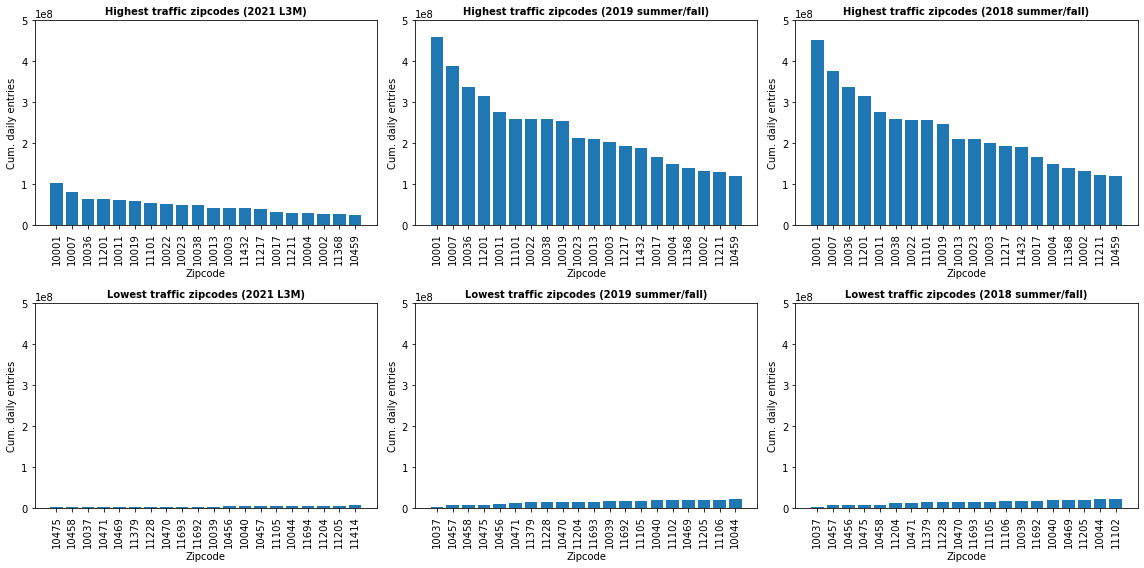

In [26]:
plt.figure(figsize=[16,8])

# 2021 high and low volume zips
plt.subplot(2,3,1)
plt.bar(x=zip_hv_total_2021.ZIPCODE,height=zip_hv_total_2021.DAILY_ENTRIES)
plt.xticks(rotation=90)
plt.title('Highest traffic zipcodes (2021 L3M)',fontsize=10,weight='bold',color='black')
plt.xlabel('Zipcode')
plt.ylabel('Cum. daily entries')
plt.ylim(0,.5e9)

plt.subplot(2,3,4)
plt.bar(x=zip_lv_total_2021.ZIPCODE,height=zip_lv_total_2021.DAILY_ENTRIES)
plt.xticks(rotation=90)
plt.title('Lowest traffic zipcodes (2021 L3M)',fontsize=10,weight='bold',color='black')
plt.xlabel('Zipcode')
plt.ylabel('Cum. daily entries')
plt.ylim(0,.5e9)

# 2019 high and low volume zips
plt.subplot(2,3,2)
plt.bar(x=zip_hv_total_2019.ZIPCODE,height=zip_hv_total_2019.DAILY_ENTRIES)
plt.xticks(rotation=90)
plt.title('Highest traffic zipcodes (2019 summer/fall)',fontsize=10,weight='bold',color='black')
plt.xlabel('Zipcode')
plt.ylabel('Cum. daily entries')
plt.ylim(0,.5e9)

plt.subplot(2,3,5)
plt.bar(x=zip_lv_total_2019.ZIPCODE,height=zip_lv_total_2019.DAILY_ENTRIES)
plt.xticks(rotation=90)
plt.title('Lowest traffic zipcodes (2019 summer/fall)',fontsize=10,weight='bold',color='black')
plt.xlabel('Zipcode')
plt.ylabel('Cum. daily entries')
plt.ylim(0,.5e9)

# 2018 high and low volume zips
plt.subplot(2,3,3)
plt.bar(x=zip_hv_total_2018.ZIPCODE,height=zip_hv_total_2018.DAILY_ENTRIES)
plt.xticks(rotation=90)
plt.title('Highest traffic zipcodes (2018 summer/fall)',fontsize=10,weight='bold',color='black')
plt.xlabel('Zipcode')
plt.ylabel('Cum. daily entries')
plt.ylim(0,.5e9)

plt.subplot(2,3,6)
plt.bar(x=zip_lv_total_2018.ZIPCODE,height=zip_lv_total_2018.DAILY_ENTRIES)
plt.xticks(rotation=90)
plt.title('Lowest traffic zipcodes (2018 summer/fall)',fontsize=10,weight='bold',color='black')
plt.xlabel('Zipcode')
plt.ylabel('Cum. daily entries')
plt.ylim(0,.5e9)

plt.tight_layout()
plt.savefig('mta_traffic_by_year.svg')

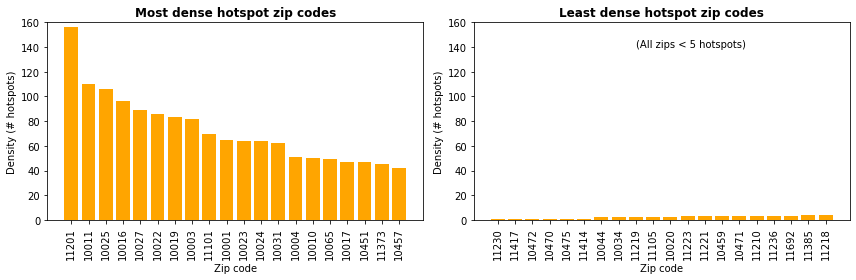

In [27]:
# plot hotspot count for top/bottom 20 zips
plt.figure(figsize=[12,4])

plt.subplot(1,2,1)
plt.bar(x=hi_dens_wifi_zips.ZIPCODE,height=hi_dens_wifi_zips.DENSITY,color='orange')
plt.xticks(rotation=90)
plt.title('Most dense hotspot zip codes',fontsize=12,weight='bold',color='black')
plt.xlabel('Zip code')
plt.ylabel('Density (# hotspots)')
plt.ylim(0,160)

plt.subplot(1,2,2)
plt.bar(x=lo_dens_wifi_zips.ZIPCODE,height=lo_dens_wifi_zips.DENSITY,color='orange')
plt.xticks(rotation=90)
plt.title('Least dense hotspot zip codes',fontsize=12,weight='bold',color='black')
plt.xlabel('Zip code')
plt.ylabel('Density (# hotspots)')
plt.ylim(0,160)
plt.annotate('(All zips < 5 hotspots)',xy=(8,140))

plt.tight_layout()
plt.savefig('wifi_dens.svg')

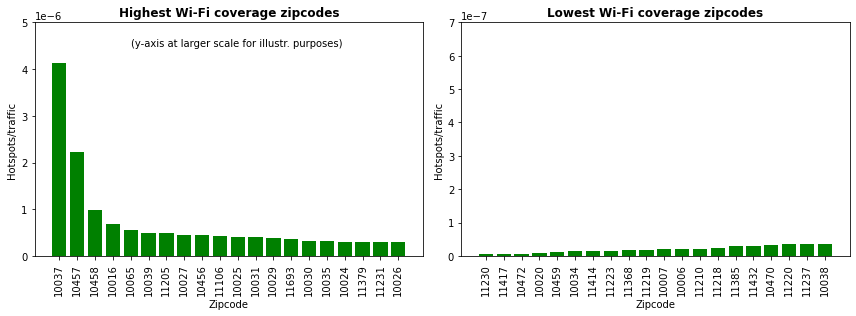

In [28]:
# plot wifi coverage across zips
plt.figure(figsize=[12,4.5])

plt.subplot(1,2,1)
plt.bar(x=hi_wifi_coverage.ZIPCODE,height=hi_wifi_coverage.HOTSPOT_COVERAGE,color='green')
plt.xticks(rotation=90)
plt.title('Highest Wi-Fi coverage zipcodes',fontsize=12,weight='bold',color='black')
plt.xlabel('Zipcode')
plt.ylabel('Hotspots/traffic')
plt.ylim(0,5e-6)
plt.annotate('(y-axis at larger scale for illustr. purposes)',xy=(4,4.5e-6))


plt.subplot(1,2,2)
plt.bar(x=lo_wifi_coverage.ZIPCODE,height=lo_wifi_coverage.HOTSPOT_COVERAGE,color='green')
plt.xticks(rotation=90)
plt.title('Lowest Wi-Fi coverage zipcodes',fontsize=12,weight='bold',color='black')
plt.xlabel('Zipcode')
plt.ylabel('Hotspots/traffic')
plt.ylim(0,7e-7)

plt.tight_layout()
plt.savefig('wifi_coverage.svg',transparent=True)

In [29]:
zip_daily.describe()

,DENSITY,DAILY_ENTRIES,HOTSPOT_COVERAGE
count,124.000000,1.240000e+02,1.240000e+02
mean,24.282258,1.883103e+08,2.043299e-07
std,26.312864,1.741066e+08,4.282881e-07
min,1.000000,6.282892e+06,4.458601e-09
25%,6.000000,8.479530e+07,4.999155e-08
50%,17.000000,1.390212e+08,1.224496e-07
75%,30.250000,2.148417e+08,2.188584e-07
max,156.000000,1.014902e+09,4.138222e-06


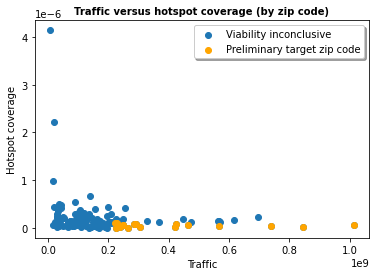

In [30]:
# mask for scatter plot below
# DAILY_ENTRIES based on >75th percentile of traffic (we want as high volume stations as pragmatic)
# HOTSPOT_COVERAGE based on bottom half of group stat (we want low coverage)
zip_dens_mask = ((zip_daily['DAILY_ENTRIES'] > 2.148417e8) &
                  (zip_daily['HOTSPOT_COVERAGE'] < 1.224496e-7))

# scatter of total zip traffic vs density
plt.scatter(x=zip_daily.DAILY_ENTRIES,y=zip_daily.HOTSPOT_COVERAGE)
plt.scatter(x=zip_daily[zip_dens_mask].DAILY_ENTRIES,y=zip_daily[zip_dens_mask].HOTSPOT_COVERAGE,color='orange')
plt.title('Traffic versus hotspot coverage (by zip code)',fontsize=10,weight='bold',color='black')
plt.xlabel('Traffic')
plt.ylabel('Hotspot coverage')
plt.legend(['Viability inconclusive','Preliminary target zip code'],shadow=True)

plt.savefig('scatter.svg')

In [31]:
# screen for target zip codes above
target_zips = zip_daily[zip_dens_mask].groupby(['ZIPCODE']).DAILY_ENTRIES.sum().reset_index()

target_mask = ((zip_daily['ZIPCODE']=='10001') |
               (zip_daily['ZIPCODE']=='10002') |
               (zip_daily['ZIPCODE']=='10006') |
               (zip_daily['ZIPCODE']=='10007') |
               (zip_daily['ZIPCODE']=='10012') |
               (zip_daily['ZIPCODE']=='10013') |
               (zip_daily['ZIPCODE']=='10014') |
               (zip_daily['ZIPCODE']=='10036') |
               (zip_daily['ZIPCODE']=='10038') |
               (zip_daily['ZIPCODE']=='10459') |
               (zip_daily['ZIPCODE']=='10467') |
               (zip_daily['ZIPCODE']=='10468') |
               (zip_daily['ZIPCODE']=='11207') |
               (zip_daily['ZIPCODE']=='11211') |
               (zip_daily['ZIPCODE']=='11217') |
               (zip_daily['ZIPCODE']=='11230') |
               (zip_daily['ZIPCODE']=='11368') |
               (zip_daily['ZIPCODE']=='11432'))

print(zip_daily[target_mask].DAILY_ENTRIES.sum())
print(zip_daily.DAILY_ENTRIES.sum())
print('Target zip codes account for ',round((zip_daily[target_mask].DAILY_ENTRIES.sum() / zip_daily.DAILY_ENTRIES.sum())*100),'% of commuter traffic')

7282824217.0
23350483138.0
Target zip codes account for  31 % of commuter traffic


In [32]:
zip_daily[target_mask].sort_values('DAILY_ENTRIES',ascending=False)

,ZIPCODE,DENSITY,DAILY_ENTRIES,HOTSPOT_COVERAGE
0,10001,65.0,1.014902e+09,6.404560e-08
6,10007,17.0,8.451176e+08,2.011554e-08
32,10036,29.0,7.404685e+08,3.916439e-08
34,10038,21.0,5.673270e+08,3.701569e-08
11,10013,34.0,4.645207e+08,7.319372e-08
83,11217,40.0,4.254954e+08,9.400806e-08
118,11432,13.0,4.205698e+08,3.091044e-08
104,11368,5.0,3.059955e+08,1.634011e-08
1,10002,24.0,2.928593e+08,8.195063e-08
77,11211,23.0,2.849629e+08,8.071226e-08


In [33]:
zip_daily[target_mask].sort_values('HOTSPOT_COVERAGE',ascending=True)

,ZIPCODE,DENSITY,DAILY_ENTRIES,HOTSPOT_COVERAGE
95,11230,1.0,2.242856e+08,4.458601e-09
50,10459,3.0,2.670912e+08,1.123212e-08
104,11368,5.0,3.059955e+08,1.634011e-08
6,10007,17.0,8.451176e+08,2.011554e-08
5,10006,5.0,2.382040e+08,2.099042e-08
118,11432,13.0,4.205698e+08,3.091044e-08
34,10038,21.0,5.673270e+08,3.701569e-08
32,10036,29.0,7.404685e+08,3.916439e-08
10,10012,11.0,2.436263e+08,4.515112e-08
56,10467,15.0,2.476248e+08,6.057552e-08
